## In this example, we will build a simple 2-node network. There will be a quantum memory on one node and a detector on the other node connected by a quantum channel. The topology is shown here

![optical hardware.PNG](<attachment:optical hardware.PNG>)
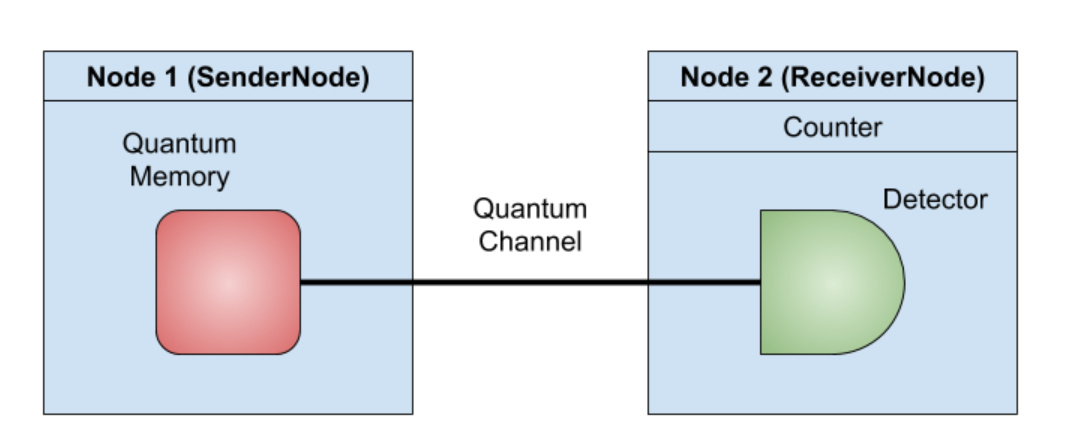

## Background 
The hardware used in this tutorial is a single atom quantum memory and a single photon detector (SPD). The quantum memory exists in one of two spin states: spin up (|↑⟩) or down (|↓⟩). When an “excite” operation is applied to the memory, consisting of a short light pulse, a memory in the |↓⟩ state may emit a photon. A memory in the |↑⟩ state will emit no photon. As a quantum device, the memory may also exist in a superposition of states. One example is the |+⟩ = 1/√2(|↑⟩ + |↓⟩) state used in this example, where the memory has an equal probability of being in the up or down spin states with the same phase.

## Step 01: Node and Hardware
To begin, we create our custom node classes. We will make two types - a SenderNode to hold the memory and send photons and a ReceiverNode to receive and detect photons. Both of our node types will inherit from **Node**, the basic node class from sequence, and we invoke the parent constructor for Node. In general, entities (such as nodes and hardware) require a string **name** and a **Timeline** in their constructor, as well as necessary parameters (for more details on timelines, see Tutorial 1).

We will now create our hardware. The detector is created easily, as no specific parameters are required (but we wish to set the efficiency to 1 to prevent errors).
The required parameters for memories are more numerous and are listed here:

**fidelity**: fidelity of entanglement. This is usually set to 0 when unentangled, but can be set to other values as it is usually replaced when entangled.

**frequency**: the frequency at which the memory can be excited. A frequency of 0 means that the memory can be excited at infinite frequency.

**efficiency**: the probability that the memory will emit a photon when it is supposed to. We set it to 1 here to prevent photon loss.

coherence_time: the time for which a memory state (other than down) is viable, given in seconds.

**wavelength**: the wavelength of emitted photons.
Next, we will add each component to the proper node using the add_component method. This method adds the component to the node’s components dictionary, which maps component names to objects. It may be accessed by outside protocols to monitor components or get their current state. We’ll put the detector on the receiver node, and the memory on the sender node.

In [176]:
from sequence.kernel.timeline import Timeline
from sequence.topology.node import Node
from sequence.components.memory import Memory
from sequence.components.detector import Detector

class SenderNode(Node):
    def __init__(self, name, timeline):
        super().__init__(name, timeline)
        
        memory_name = name + ".memory"
        memory = Memory(memory_name, timeline, fidelity=1, frequency=0,
                        efficiency=1, coherence_time=0, wavelength=500)
        self.add_component(memory)
        memory.add_receiver(self)

    def get(self, photon, **kwargs):
        self.send_qubit(kwargs['dst'], photon)

class ReceiverNode(Node):
    def __init__(self, name, timeline):
        super().__init__(name, timeline)

        detector_name = name + ".detector"
        detector = Detector(detector_name, timeline, efficiency=1)
        self.add_component(detector)
        self.set_first_component(detector_name)
        detector.owner = self

    def receive_qubit(self, src, qubit):
        self.components[self.first_component_name].get(qubit)

You may notice that the initialization methods make use of a few additional functions, and methods have been added to the node classes. These are to establish the internal hardware connections on the node. The first of these methods is the Entity.get method. All physical simulation elements, including optical hardware and nodes, inherit from this class. The get method is used to receive photons from another entity which may be further processed. The add_receiver method similarly designates another component (or components) to receive photons from the current entity. In our case, we wish to set the memory’s receiver as the SenderNode, so that the node may receive emitted photons and direct them to an inter-node quantum channel using send_qubit. This is performed in the SenderNode.get method. At the other end of the channel, the receive_qubit method is called by a quantum channel on the receiving node of a transmission. For this method, the src input specifies the name of the node sending the qubit. In our case, we don’t care about the source node, so we can ignore it. The qubit input is the transmitted photon; it is sent to the detector for measurement. This is done using the first_component_name attribute, which designates a component on a node to receive all incoming photons

## Step 2: Custom Counting Protocol
Next, we will create our custom protocols using custom classes. Let’s denote the first class as Counter, as we will be counting photon detection. The initializing method is very simple, only setting the count to 0. We then proceed to the trigger function, which will handle information from the detector. Normally, the detector will pass two arguments through this function (a reference to the specific detector and info including the detection time), but we are not concerned with these. We only wish to increment our counter.

In [177]:
class Counter:
    def __init__(self):
        self.count = 0
        

    def trigger(self, detector, info):
        self.count += 1

We then add this counter protocol to our receiver node, by modifying the initialization method. To have the counter monitor the detector, we invoke the Entity.attach method. This method ensures that any updates (such as detection events) from an entity are passed to the object specified in the method arguments.

In [178]:
class ReceiverNode(Node):
    def __init__(self, name, timeline):
        super().__init__(name, timeline)

        detector_name = name + ".detector"
        detector = Detector(detector_name, timeline, efficiency=1)
        self.add_component(detector)
        self.set_first_component(detector_name)
        detector.owner = self

        self.counter = Counter()
        detector.attach(self.counter)

## Step 3: Build the Network
We are now ready to start writing the main function of our script. The first step is to create the simulation timeline. We will use a 10 second run time, but more or less time may be needed depending on hardware parameters. Note that the runtime is given in picoseconds.

In [179]:
from sequence.kernel.timeline import Timeline
tl = Timeline(10e12)

We can then create our two network nodes using our custom node class. We only need to specify a name for each node and the timeline it belongs to:

In [180]:
node1 = SenderNode("node1", tl)
node2 = ReceiverNode("node2", tl)
node1.set_seed(0)
node2.set_seed(1)

Note that we also set the random generator seed for our nodes to ensure reproducability. Next, we create the quantum channel to provide connectivity between the nodes. We won’t need a classical channel, as we’re not sending any messages between nodes. In the initializer, we again specify the name and timeline, and include the additional required attenuation and distance parameters. We set attenuation to 0, so that we do not lose any photons in the channel (try changing it to see the effects!), and set the distance to one kilometer (note that the distance is given in meters). The set_ends method finally sets the sender and receiver for the channel, where the receiver is given as the name of the receiving node.

In [181]:
from sequence.components.optical_channel import QuantumChannel
qc = QuantumChannel("qc", tl, attenuation=0, distance=1e3)
qc.set_ends(node1, node2.name)

## Step 4: Measure Memory Once
With the network built, we are ready to schedule simulation events and run our experiment. The details on scheduling events are covered in Tutorial 1, so we will not focus on them here. Let’s first run one experiment with the memory in the |↑⟩ state and observe the detection time of the single emitted photon. We can obtain the memory object using the Node.get_components_by_type method, which returns a list of matching components on the node. The memory state can then be set with the update_state method.

In [182]:
memories = node1.get_components_by_type("Memory")
memory = memories[0]
memory.update_state([complex(0), complex(1)])

We set the state of this single memory to a quantum state, given as a complex array of coefficients for the |↑⟩ and |↓⟩ states. Let’s also change our counter slightly to record the detection time. This can be done by accessing the 'time' field of the detector info:

In [183]:
class Counter:
    def __init__(self):
        self.count = 0
        self.time = 0

    def trigger(self, detector, info):
        self.count += 1
        self.time = info['time']

We must also schedule an excite event for the memory, which will send a photon to a connected node supplied as an argument (in this case, we’ll use "node2"). Let’s put it at time 0:



In [184]:
from sequence.kernel.process import Process
from sequence.kernel.event import Event

process = Process(memory, "excite", ["node2"])
event = Event(0, process)
tl.schedule(event)

We can then run our single experiment. The procedure to initialize and run the timeline is the same as Tutorial 1:



In [185]:
tl.init()
tl.run ()

We should see that the count field of our Counter class is now 1, and that we have a detection time greater than 0 resulting from the quantum channel delay. Quantum channel delay is calculated based on the speed of light in an optical fiber and the length of the fiber (delay = L / c). We can view the detection and detection time as follows:

In [186]:
#print("detection count: {}".format(node2.counter.count))
#print("detection time: {}".format(node2.counter.time))

## Step 5: Repeated Operation
Next, let’s repeatedly set the memeory to the |+⟩ state and record detection events. To give us a clean state, we’ll remove the code we wrote for step 4.

The events we wish to schedule are all for the memory. We want to first set it to a |+⟩ state with the update_state method, and then excite the memory to measure emitted photons with the excite method. The update_state method will require a plus state as input. The excite method needs an argument for the desired destination node, so we’ll supply the name of our node2. We’ll schedule both of these at a predetermined period.

To manage all of these requirements, we’ll write our second protocol class, the Sender. The protocol will need a reference to the local node, as well as the name of the memory to trigger. Requiring a node and the names of local hardware is typical of protocols in SeQUeNCe. We’ll include all memory modification in the start method, which will activate the protocol.


In [187]:
import math

class Sender:
    def __init__(self, own, memory_name):
        self.own = own
        self.memory = own.components[memory_name]

    def start(self, period):
        process1 = Process(self.memory, "update_state", [[complex(math.sqrt(1/2)), complex(math.sqrt(1/2))]])
        process2 = Process(self.memory, "excite", ["node2"])
        for i in range(NUM_TRIALS):
            event1 = Event(i * period, process1)
            event2 = Event(i * period + (period / 2), process2)
            self.own.timeline.schedule(event1)
            self.own.timeline.schedule(event2)

We’ll then place this protocol in the SenderNode class:



In [188]:
class SenderNode(Node):
    def __init__(self, name, timeline):
        super().__init__(name, timeline)
        memory_name = name + ".memory"
        memory = Memory(memory_name, timeline, fidelity=1, frequency=0,
                        efficiency=1, coherence_time=0, wavelength=500)
        self.add_component(memory)
        memory.add_receiver(self)

        self.sender = Sender(self, memory_name)

    def get(self, photon, **kwargs):
        self.send_qubit(kwargs['dst'], photon)

## Step 6: Running and Output
The procedure to initialize and run the timeline is the same as Tutorial 1. We will also add a call to the start method of our protocol, using a calculated period. We’ll use a predetermined frequency FREQUENCY (given in Hz) for a set number of trials NUM_TRIALS.

In [189]:
tl.init()
period = int(1e12 / FREQUENCY)
node1.sender.start(period)
tl.run()

AttributeError: 'SenderNode' object has no attribute 'sender'

To access the results of our simulation, we just need the count parameter of our custom counter class. We’ll read it, and present the number of detections we had as a percent of the number of excite operations:



In [ ]:
print("percent measured: {}%".format(100 * node2.counter.count / NUM_TRIALS))
